In [75]:
# Imports 
import os
import xml.etree.ElementTree as et
import pandas as pd
from itertools import chain

import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD as LSA
import random
random.seed(13)


#visualisation stuff
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline

import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load('en')
tokenizer = Tokenizer(nlp.vocab)


In [76]:
# Load data 
PATH = "../xml/"
extension = ".xml"

def load_order(PATH, extension):
    """
    Custom function for loading and sorting the xml files from the TOTA dataset.
    Returns an array of filenames sorted by the number in the file name.
    """
    files = []
    for filename in os.listdir(PATH):
        if filename == ".ipynb_checkpoints":
            continue
        files.append(filename.split(".")[0]) # remove .xml
    files.sort(key=lambda x:int(x.split("_")[1])) # sort files based on file number 

    files = [file + extension for file in files]
#     print(files)
    return files

files = load_order(PATH, extension)

In [210]:
def xml2list(file):
    """
    Custom function for parsing and outputing the data into arrays.
    Returns two array's the extracted column names and content for each column.
    """
    parsed_xml = et.parse(file)

    root = parsed_xml.getroot()

    meta_column_names = []
    meta_column_content = []

    for item in root[0]:
        grandchild = item.findall(".//")
        if grandchild:
            grandstore = []
            #print(item.tag)
            meta_column_names.append(item.tag)
            for x in grandchild:
                grandstore.append(int(x.attrib.get('n')))
                #print(x.tag +":", x.attrib)
            meta_column_content.append(grandstore)

        else:
            #print(item.tag +":", item.text)
            meta_column_names.append(item.tag)
            meta_column_content.append(item.text)
            
    return meta_column_names, meta_column_content
    
    
def xml2list_text(file):
    """
    Custom function for parsing and outputing the data into arrays.
    Returns two array's the extracted column names and content for each column.
    """

    parsed_xml = et.parse(file)
    root = parsed_xml.getroot()
    chapters = []
    article_store = []
    
    treaty_text = ''
    
    for item in root[1]:
        chapter_name = item.attrib.get('name')
#         print("chapter: " + item.attrib.get('name'))
        chapters.append(chapter_name)
        if chapter_name == None:
            continue
        treaty_text += chapter_name + " "
        
        articles = item.findall("article")
        for article in articles:
#             print(article.attrib.get('name'))
            art_no = article.attrib.get('number')
            art_text =  article.text
            article_store.append(art_no)
            if art_no == None:
                continue
#             print(art_no)
            treaty_text += art_no + " "
            treaty_text += art_text + " "
        
            
    return len(chapters), len(article_store), treaty_text

In [211]:
textdf = pd.DataFrame()

chapter_numbers = []
article_numbers = []
treaty_text = []

for i in range(0, len(files)):
    chapter_no, article_no, text = xml2list_text(PATH + files[i])
    chapter_numbers.append(chapter_no)
    article_numbers.append(article_no)
    treaty_text.append(text.lower())

textdf["chapter_number"] = chapter_numbers
textdf["article_number"] = article_numbers
textdf["treaty_text"] = treaty_text

In [212]:
with open('alltext.txt', 'w') as f:
    for item in t_txt:
        f.write("%s\n" % item)

In [213]:
from collections import Counter

with open("alltext.txt") as f:
    wordcount = Counter(f.read().split())

stop_words_law = []
for item, frequency in wordcount.most_common(2000):
    stop_words_law.append(item)
stop_words_law.append('\n')

In [214]:
dfcols, null = xml2list(PATH + files[3])
totadf = pd.DataFrame(columns=dfcols)

for i in range(0, len(files)):
    dfcolstmp, datatmp = xml2list(PATH + files[i])
    tmp_df = pd.DataFrame([datatmp], columns=dfcolstmp)
    tmp_df = tmp_df.loc[:,~tmp_df.columns.duplicated()] #very important! removes duplicate columns note that it removes the multiple "source" columnsns
    totadf = totadf.loc[:,~totadf.columns.duplicated()]#very important! removes duplicate columns note that it removes the multiple "source" columnsns 
    totadf = pd.concat([totadf,tmp_df], axis=0, sort=False)
totadf = totadf.reset_index(drop=True)
totadf = pd.concat([totadf, textdf], axis=1)

In [215]:
totadf.head()

,name,type,wto_rta_id,treaty_identifier,status,notification,date_signed,date_into_force,date_notification,end_implementation,...,composition,region,parties_wto,crossregional,related_agreement_wto_id,language,source,chapter_number,article_number,treaty_text
0,Japan - Thailand,Free Trade Agreement & Economic Integration Ag...,1,1,In Force,GATT Art. XXIV & GATS Art. V,2007-04-03,2007-11-01,2007-10-25,2022-12-31,...,Bilateral,East Asia,Yes,No,NaN,en,http://www.mofa.go.jp/region/asia-paci/thailan...,17,175,preamble general provisions article 1 the obje...
1,Egypt - Turkey,Free Trade Agreement,2,2,In Force,Enabling Clause,2005-12-27,2007-03-01,2007-10-05,2020-12-30,...,Bilateral,Africa; Europe,Yes,Yes,NaN,en,http://rtais.wto.org/rtadocs/2/TOA/English/Egy...,8,40,preamble article 1 the parties shall gradually...
2,Chile - Japan,Free Trade Agreement & Economic Integration Ag...,3,3,In Force,GATT Art. XXIV & GATS Art. V,2007-03-27,2007-09-03,2007-08-24,2022-12-31,...,Bilateral,South America; East Asia,Yes,Yes,NaN,en,http://www.mofa.go.jp/region/latin/chile/joint...,21,201,preamble general provisions article 1 the part...
3,Central European Free Trade Agreement (CEFTA) ...,Free Trade Agreement,4,4,In Force,GATT Art. XXIV,2006-12-19,2007-05-01,2007-07-26,2008-12-30,...,Plurilateral,Europe; Commonwealth of Independent States (CIS),No,Yes,54,en,http://www.cefta.int/sites/default/files/CEFTA...,3,0,
4,EFTA - Egypt,Free Trade Agreement,5,5,In Force,GATT Art. XXIV,2007-01-27,2007-08-01,2007-07-17,2020-12-30,...,Bilateral; One Party is an RTA,Africa; Europe,Yes,Yes,NaN,en,http://www.efta.int/~/media/Documents/legal-te...,11,52,preamble general provisions article 1 1. egypt...


In [218]:
totadf['year_signed'] = totadf.date_signed.map( lambda x: pd.to_datetime(x).year)
totadf = totadf[totadf.language == 'en']
new = ['treaty_identifier', 'chapter_number', 'article_number', 'treaty_text', 'year_signed']

totadf_emb = totadf[new]
totadf_emb = totadf_emb.reset_index()
totadf_emb.head()

,index,treaty_identifier,chapter_number,article_number,treaty_text,year_signed
0,0,1,17,175,preamble general provisions article 1 the obje...,2007
1,1,2,8,40,preamble article 1 the parties shall gradually...,2005
2,2,3,21,201,preamble general provisions article 1 the part...,2007
3,3,4,3,0,,2006
4,4,5,11,52,preamble general provisions article 1 1. egypt...,2007


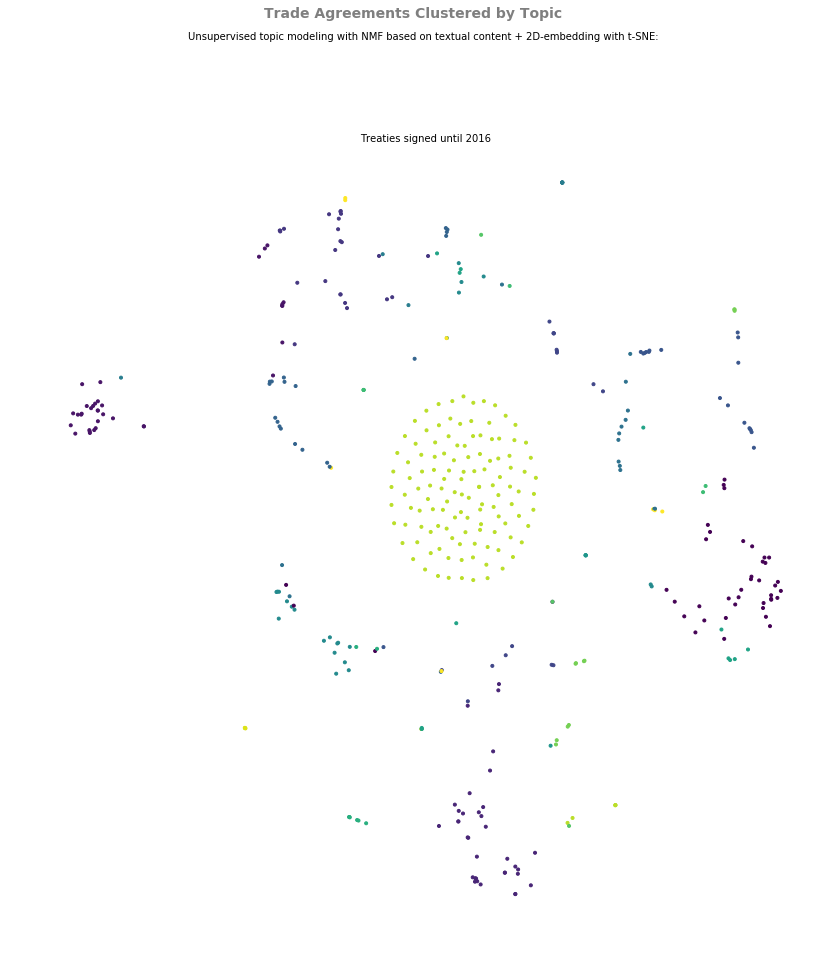

In [222]:
# Parameters that I tweaked - could probably spend a whole week trying to find the best combination - but this selection seems to work just fine
# for number in range(20,150,10):
n_features = 1000
n_topics = 20 # 5 because I want it to try and cluster based on the 5 treaty types
n_top_words = 3


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
#I convert a collection of raw documents into a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features, stop_words=stop_words_law)
#retearns a term-document matrix
tfidf = tfidf_vectorizer.fit_transform(totadf_emb['treaty_text'])
# This is where the non negative matrix factorization happens - in short it is a form of dimensionality reduction
nmf = LSA(n_components=n_topics, n_iter=5, random_state=0).fit(tfidf)

# print("Topics found via LSA:")
# need to print the words most related to the seperate topics - quite difficult to differentiate by hand. 
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# print_top_words(nmf, tfidf_feature_names, n_top_words)

nmf_embedding = nmf.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

# return the most representative documents for the different topics (they are classified by their treaty identifier)
top_idx = np.argsort(nmf_embedding, axis=0)[-3:]

# count = 0
# for idxs in top_idx.T:
#     print("\nTopic {}:".format(count))
#     for idx in idxs:
#         print(totadf.iloc[idx][['name', 'region', 'type']])
#     count += 1

topics = list(range(n_topics)) #these are hand coded topics and probably do not represent the actual topics 

tsne = TSNE(n_iter=5000, random_state=3211,learning_rate=100, perplexity=50) # run t-sne with the various parameters
tsne_embedding = tsne.fit_transform(nmf_embedding) 
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y']) # turn the results into a dataframe
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1) # attach a hue column so that we can later color each cluster differently
tsne_embedding['year'] = totadf['year_signed'] # attach a year column so that we can see the evolution of the treaties over time. 

color_list = plt.cm.viridis(np.linspace(0, 1, n_topics))

legend_list = []

for i in range(len(topics)):   
    color = color_list[i]
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

fig, axs = plt.subplots(figsize=(14, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

for year, idx in zip([2016], range(1)):
    data = tsne_embedding.loc[(totadf_emb['year_signed']<=year)]
    scatter = axs.scatter(data=data,x='x',y='y',s=9,c=data['hue'], cmap='viridis')
    axs.set_title('Treaties signed until {}'.format(year),**{'fontsize':'10'})
    axs.axis('off')

plt.suptitle("Trade Agreements Clustered by Topic",**{'fontsize':'14','weight':'bold'},alpha=0.5)
plt.figtext(.51,0.95,'Unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')


# fig.legend(legend_list, topics, loc=(0.2,0.89), ncol=5)
plt.subplots_adjust(top=0.85)

plt.savefig(f'ToTa_Documents_15_.png', format='png', dpi=200)

In [197]:
# tsne_embedding.head()

,x,y,hue,year
0,5.248753,-14.089790,9,2007.0
1,1.545438,10.078738,4,2005.0
2,0.032933,-14.201297,0,2007.0
3,-2.382143,-2.954867,17,2006.0
4,2.006824,12.395350,11,2007.0


In [203]:
# tsne_embedding.loc[(tsne_embedding['hue'] == 0)]

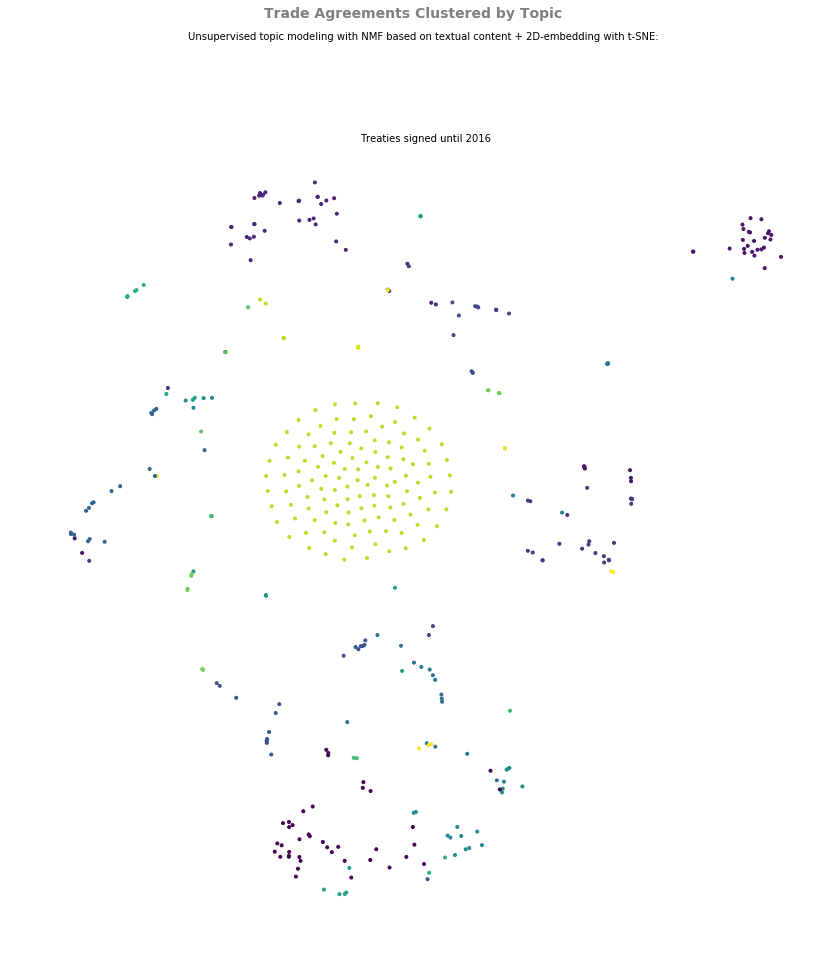

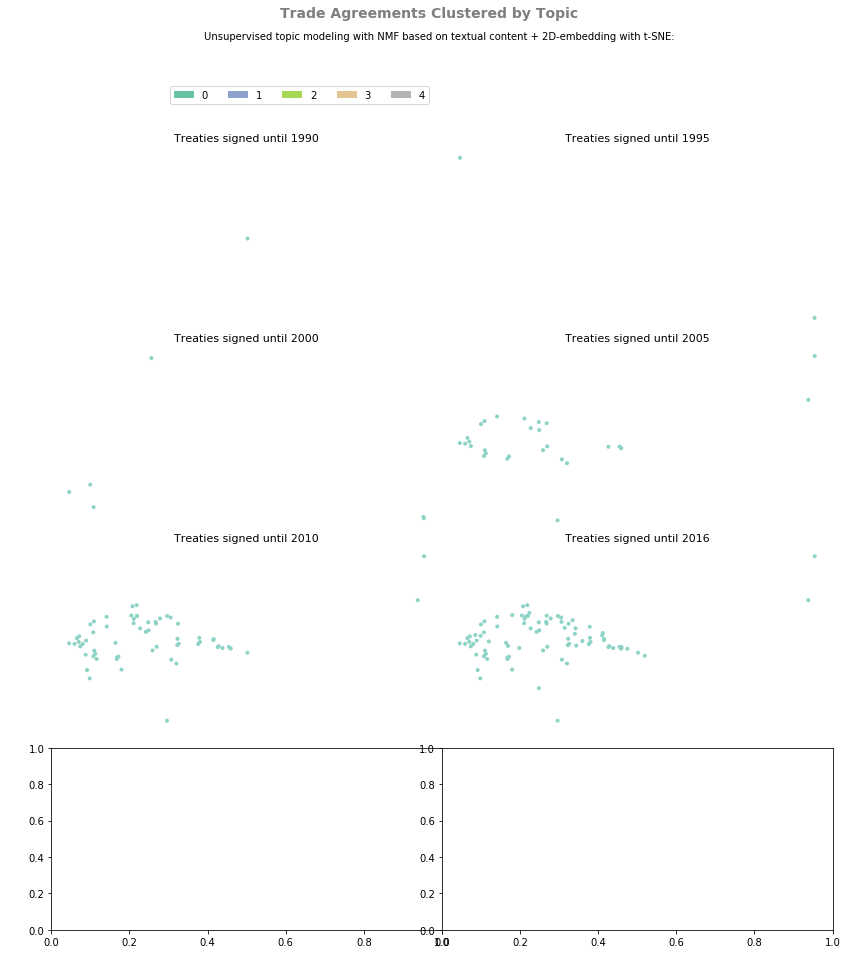

In [163]:
fig, axs = plt.subplots(ncols=2,nrows=4,figsize=(14, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()

for year, idx in zip([1990,1995,2000,2005,2010,2016], range(8)):
    data = tsne_embedding.loc[(totadf_emb['year_signed']<=year) &(tsne_embedding['hue'] == 0)]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=9,c=data['hue'], cmap='Set3')
    axs[idx].set_title('Treaties signed until {}'.format(year),**{'fontsize':'11'})
    axs[idx].axis('off')

plt.suptitle("Trade Agreements Clustered by Topic",**{'fontsize':'14','weight':'bold'}, alpha=0.5)
plt.figtext(.51,0.95,'Unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')


fig.legend(legend_list, topics, loc=(0.2,0.89), ncol=5)
plt.subplots_adjust(top=0.85)

# plt.savefig('ToTa.png', format='png', dpi=1000)